# Data-driven Fairness Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Load the Census-Income dataset from OpenML
data = fetch_openml(data_id=45068, as_frame=True)
df = data.frame

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  float64 
 1   fnlwgt          48842 non-null  float64 
 2   education-num   48842 non-null  float64 
 3   capital-gain    48842 non-null  float64 
 4   capital-loss    48842 non-null  float64 
 5   hours-per-week  48842 non-null  float64 
 6   workclass       48842 non-null  category
 7   education       48842 non-null  category
 8   marital-status  48842 non-null  category
 9   occupation      48842 non-null  category
 10  relationship    48842 non-null  category
 11  race            48842 non-null  category
 12  sex             48842 non-null  category
 13  native-country  48842 non-null  category
 14  class           48842 non-null  object  
dtypes: category(8), float64(6), object(1)
memory usage: 3.0+ MB


In [5]:
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,sex,native-country,class
0,19.0,134974.0,10.0,0.0,0.0,20.0,nan,Some-college,Never-married,nan,Own-child,White,Female,United-States,<=50K
1,41.0,195096.0,13.0,0.0,0.0,50.0,Self-emp-inc,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
2,31.0,152109.0,9.0,0.0,0.0,50.0,Private,HS-grad,Never-married,Exec-managerial,Not-in-family,White,Male,United-States,<=50K
3,40.0,202872.0,12.0,0.0,0.0,45.0,Private,Assoc-acdm,Never-married,Adm-clerical,Own-child,White,Female,United-States,<=50K
4,35.0,98989.0,5.0,0.0,0.0,38.0,nan,9th,Divorced,nan,Own-child,Amer-Indian-Eskimo,Male,United-States,<=50K


In [6]:
# Create "is born in america" column
df['is_born_in_america'] = df['native-country'].apply(lambda country: 1 if country == 'United-States' else 0)

# Drop "native-country" column
df.drop(columns=['native-country'], inplace=True)

In [7]:
# Select features and target variable
X = df.drop(columns=['class'])
y = df['class']

In [8]:
# One-hot encode categorical features
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
encoder = OneHotEncoder(drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]).toarray(), columns=encoder.get_feature_names(categorical_columns))
X = pd.concat([X.drop(columns=categorical_columns), X_encoded], axis=1)

C:\Users\goekc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Add the "is born in america" column to X
X['is_born_in_america'] = df['is_born_in_america']

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39073, 60)
X_test shape: (9769, 60)
y_train shape: (39073,)
y_test shape: (9769,)


In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 60 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   39073 non-null  float64
 1   fnlwgt                                39073 non-null  float64
 2   education-num                         39073 non-null  float64
 3   capital-gain                          39073 non-null  float64
 4   capital-loss                          39073 non-null  float64
 5   hours-per-week                        39073 non-null  float64
 6   is_born_in_america                    39073 non-null  int64  
 7   workclass_Local-gov                   39073 non-null  float64
 8   workclass_Never-worked                39073 non-null  float64
 9   workclass_Private                     39073 non-null  float64
 10  workclass_Self-emp-inc                39073 non-null  float64
 11  workclass_S

In [12]:
# Convert target variable to numerical values
y_train_numeric = y_train.apply(lambda x: 0 if x == '<=50K' else 1)
y_test_numeric = y_test.apply(lambda x: 0 if x == '<=50K' else 1)

In [13]:
# Define fairness metrics
def equal_opportunity_difference(y_true, y_pred, sensitive_features):
    # Calculate true positive rates for each group
    positive_rates = []
    for group in np.unique(sensitive_features):
        mask = (sensitive_features == group)
        true_positives = np.sum((y_true == 1) & (y_pred == 1) & mask)
        actual_positives = np.sum((y_true == 1) & mask)
        positive_rate = true_positives / actual_positives
        positive_rates.append(positive_rate)
    
    # Calculate the equal opportunity difference
    eq_diff = max(positive_rates) - min(positive_rates)
    return eq_diff

def predictive_parity_difference(y_true, y_pred, sensitive_features):
    # Calculate precision for each group
    precisions = []
    for group in np.unique(sensitive_features):
        mask = (sensitive_features == group)
        true_positives = np.sum((y_true == 1) & (y_pred == 1) & mask)
        false_positives = np.sum((y_true == 0) & (y_pred == 1) & mask)
        precision = true_positives / (true_positives + false_positives)
        precisions.append(precision)
    
    # Calculate the predictive parity difference
    pp_diff = max(precisions) - min(precisions)
    return pp_diff

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39073 entries, 37193 to 15795
Data columns (total 60 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   39073 non-null  float64
 1   fnlwgt                                39073 non-null  float64
 2   education-num                         39073 non-null  float64
 3   capital-gain                          39073 non-null  float64
 4   capital-loss                          39073 non-null  float64
 5   hours-per-week                        39073 non-null  float64
 6   is_born_in_america                    39073 non-null  int64  
 7   workclass_Local-gov                   39073 non-null  float64
 8   workclass_Never-worked                39073 non-null  float64
 9   workclass_Private                     39073 non-null  float64
 10  workclass_Self-emp-inc                39073 non-null  float64
 11  workclass_S

In [16]:
# Train and evaluate models with different feature counts
feature_counts = [15, 36, 59]  # Different feature counts to try

for num_features in feature_counts:
    # Select subset of features
    selected_features = X_train.columns[:num_features].tolist() + ['sex_Male']  # sex_Male = 0 means female
    X_train_subset = X_train[selected_features]
    X_test_subset = X_test[selected_features]
    
    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_model.fit(X_train_subset, y_train_numeric)
    
    # Train Logistic Regression model
    lr_model = LogisticRegression(random_state=42)
    lr_model.fit(X_train_subset, y_train_numeric)
    
    # Make predictions
    prob_xgb = xgb_model.predict_proba(X_test_subset)[:,1]
    prob_lr = lr_model.predict_proba(X_test_subset)[:,1]
    
    # Evaluate models
    gini_xgb = roc_auc_score(y_test_numeric, prob_xgb) * 2 - 1
    gini_lr = roc_auc_score(y_test_numeric, prob_lr) * 2 - 1
    
    # Perform fairness analysis
    protected_group = X_test['sex_Male']
    
    eq_diff_xgb = equal_opportunity_difference(y_test_numeric, prob_xgb >= 0.5, protected_group)
    pp_diff_xgb = predictive_parity_difference(y_test_numeric, prob_xgb <= 0.5, protected_group)
    
    eq_diff_lr = equal_opportunity_difference(y_test_numeric, prob_lr >= 0.5, protected_group)
    pp_diff_lr = predictive_parity_difference(y_test_numeric, prob_lr <= 0.5, protected_group)
    
    print(f"Feature Count: {num_features}")
    print(f"Gini [XGB]: {gini_xgb*100:.1f}%")
    print(f"Equal Opportunity Difference [XGB]: {eq_diff_xgb:.4f}")
    print(f"Predictive Parity Difference [XGB]: {pp_diff_xgb:.4f}")
    print(f"Gini [LR] : {gini_lr*100:.1f}%")
    print(f"Equal Opportunity Difference [LR]: {eq_diff_lr:.4f}")
    print(f"Predictive Parity Difference [LR]: {pp_diff_lr:.4f}")
    print("="*30)


Feature Count: 15
Gini [XGB]: 78.2%
Equal Opportunity Difference [XGB]: 0.2126
Predictive Parity Difference [XGB]: 0.1009
Gini [LR] : 14.0%
Equal Opportunity Difference [LR]: 0.0315
Predictive Parity Difference [LR]: 0.1739
Feature Count: 36
Gini [XGB]: 84.3%
Equal Opportunity Difference [XGB]: 0.0948
Predictive Parity Difference [XGB]: 0.0965
Gini [LR] : 13.5%
Equal Opportunity Difference [LR]: 0.0320
Predictive Parity Difference [LR]: 0.1740
Feature Count: 59
Gini [XGB]: 85.7%
Equal Opportunity Difference [XGB]: 0.0975
Predictive Parity Difference [XGB]: 0.0892
Gini [LR] : 13.5%
Equal Opportunity Difference [LR]: 0.0320
Predictive Parity Difference [LR]: 0.1740


In [17]:
##### Plotting and visualization 

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']
data = pd.read_csv(url, names=column_names, sep=',\s*', engine='python')


In [19]:
# Mapping dictionary for education levels
education_mapping = {
    'Preschool': 'Preschool',
    '1st-4th': 'Elementary School',
    '5th-6th': 'Elementary School',
    '7th-8th': 'Middle School',
    '9th': 'High School',
    '10th': 'High School',
    '11th': 'High School',
    '12th': 'High School',
    'HS-grad': 'High School Graduate',
    'Some-college': 'Some College',
    'Assoc-acdm': 'Associate Degree',
    'Assoc-voc': 'Associate Degree',
    'Bachelors': "Bachelor's Degree",
    'Masters': "Master's Degree",
    'Doctorate': 'Doctorate'
}

# Replace education level values with human-readable names
data['education'] = data['education'].map(education_mapping)

In [20]:
# Mapping dictionary for race
race_mapping = {
    'White': 'White',
    'Black': 'Black',
    'Asian-Pac-Islander': 'Asian-Pacific Islander',
    'Amer-Indian-Eskimo': 'Native American / Eskimo',
    'Other': 'Other'
}

# Replace race values with human-readable names
data['race'] = data['race'].map(race_mapping)

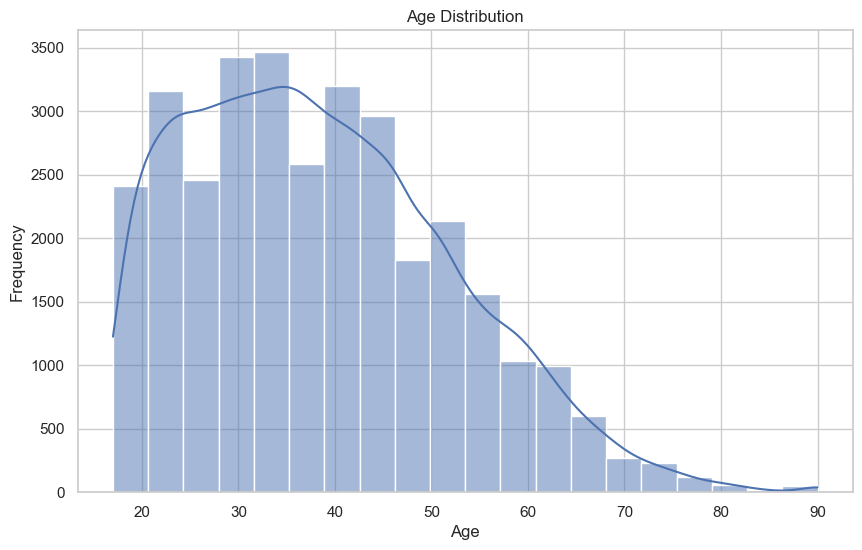

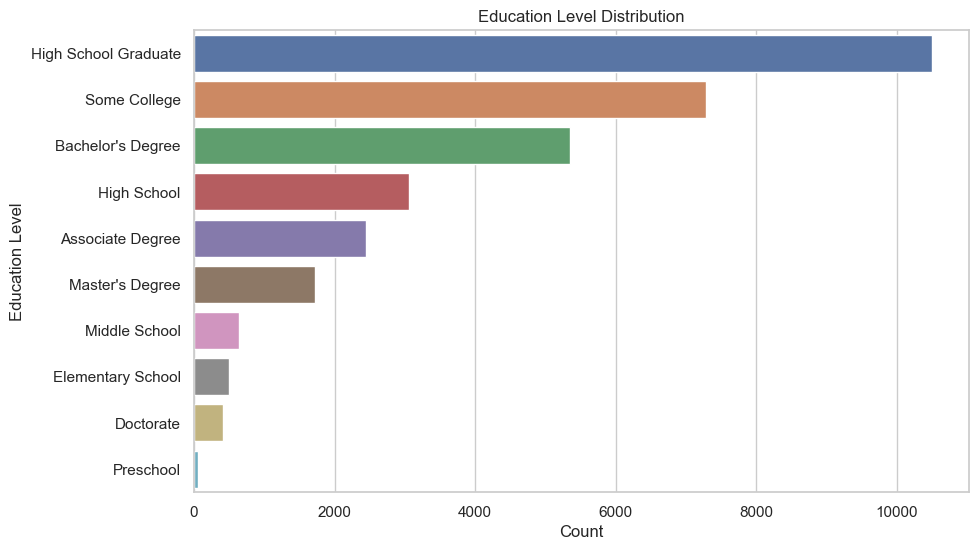

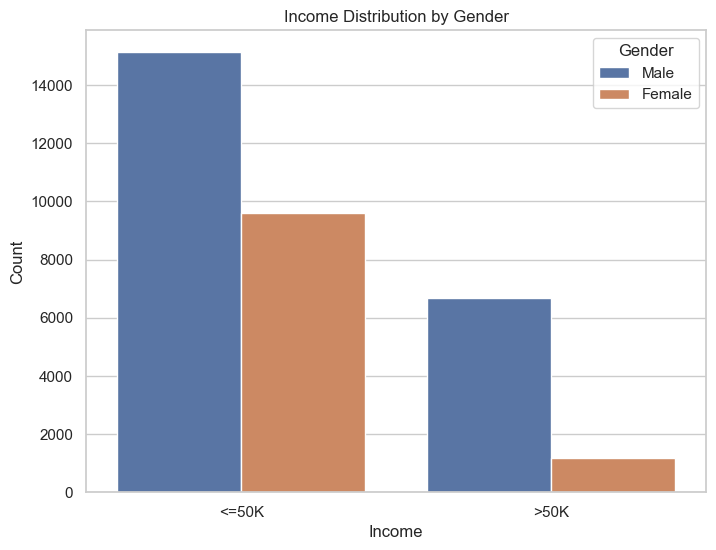

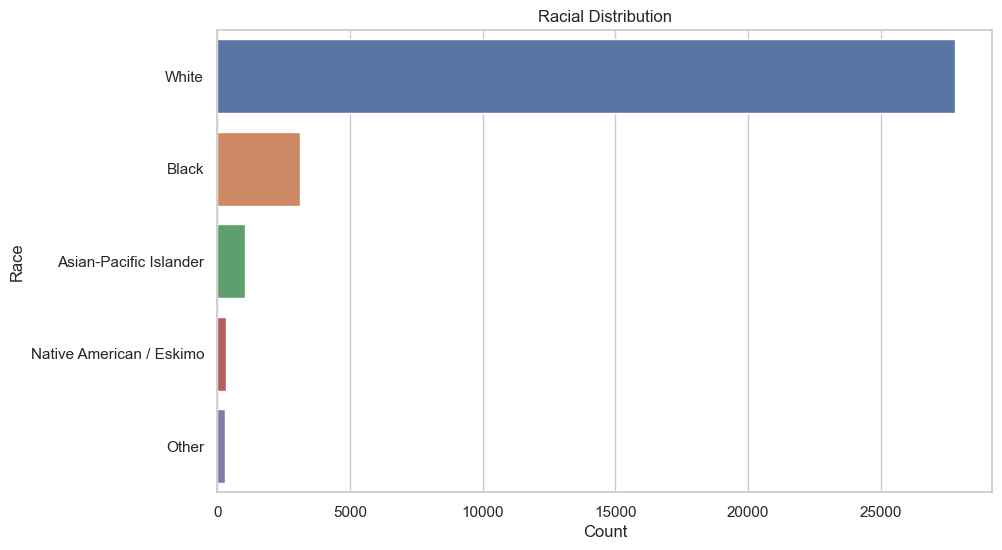

In [21]:
# Set up the visualization style
sns.set(style="whitegrid")

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Visualize education level distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='education', data=data, order=data['education'].value_counts().index)
plt.title('Education Level Distribution')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

# Visualize income distribution by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='income', hue='sex', data=data)
plt.title('Income Distribution by Gender')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

# Visualize racial distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='race', data=data, order=data['race'].value_counts().index)
plt.title('Racial Distribution')
plt.xlabel('Count')
plt.ylabel('Race')
plt.show()

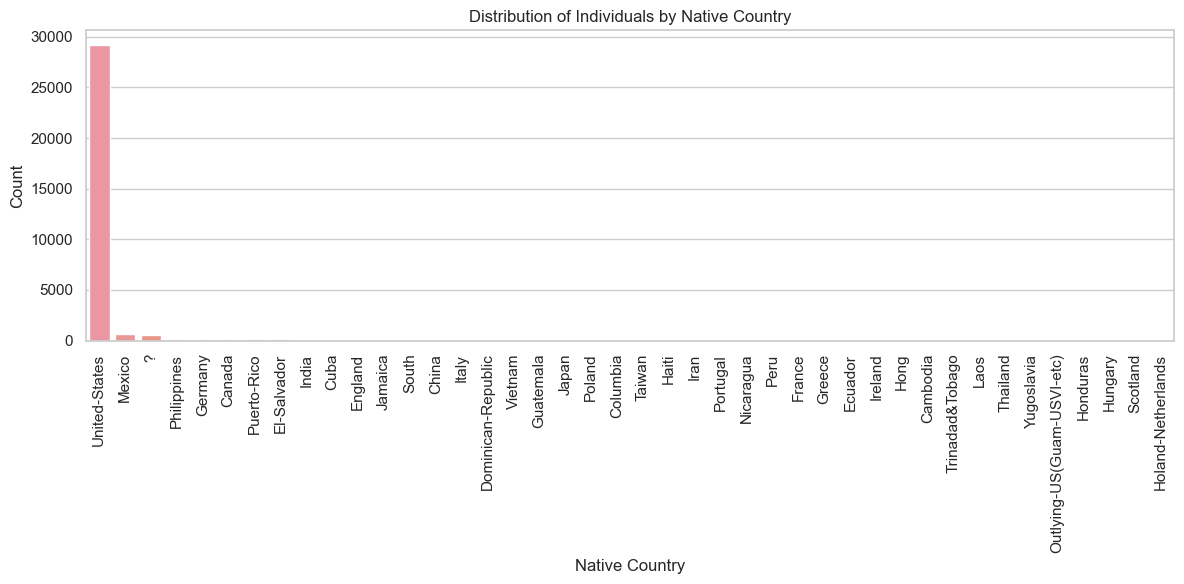

In [22]:
# Plot the distribution of individuals by native country
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='native_country', order=data['native_country'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Native Country')
plt.ylabel('Count')
plt.title('Distribution of Individuals by Native Country')
plt.tight_layout()
plt.show()

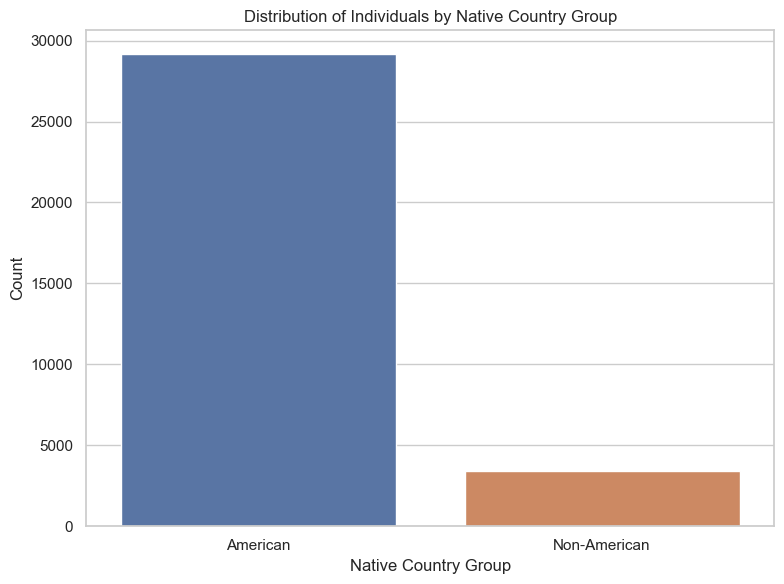

In [23]:
# Group native countries into "American" and "Non-American" categories
data['native_country_group'] = data['native_country'].apply(lambda x: 'American' if x == 'United-States' else 'Non-American')

# Plot the distribution of individuals by native country group
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='native_country_group', order=['American', 'Non-American'])
plt.xlabel('Native Country Group')
plt.ylabel('Count')
plt.title('Distribution of Individuals by Native Country Group')
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [25]:
# Data for fairness metrics
feature_counts = [15, 36, 59]
gini_xgb = [78.2, 84.3, 85.7]
equal_opp_diff_xgb = [0.2126, 0.0948, 0.0975]
predictive_parity_diff_xgb = [0.1009, 0.0965, 0.0892]
gini_lr = [14.0, 13.5, 13.5]
equal_opp_diff_lr = [0.0315, 0.0320, 0.0320]
predictive_parity_diff_lr = [0.1739, 0.1740, 0.1740]

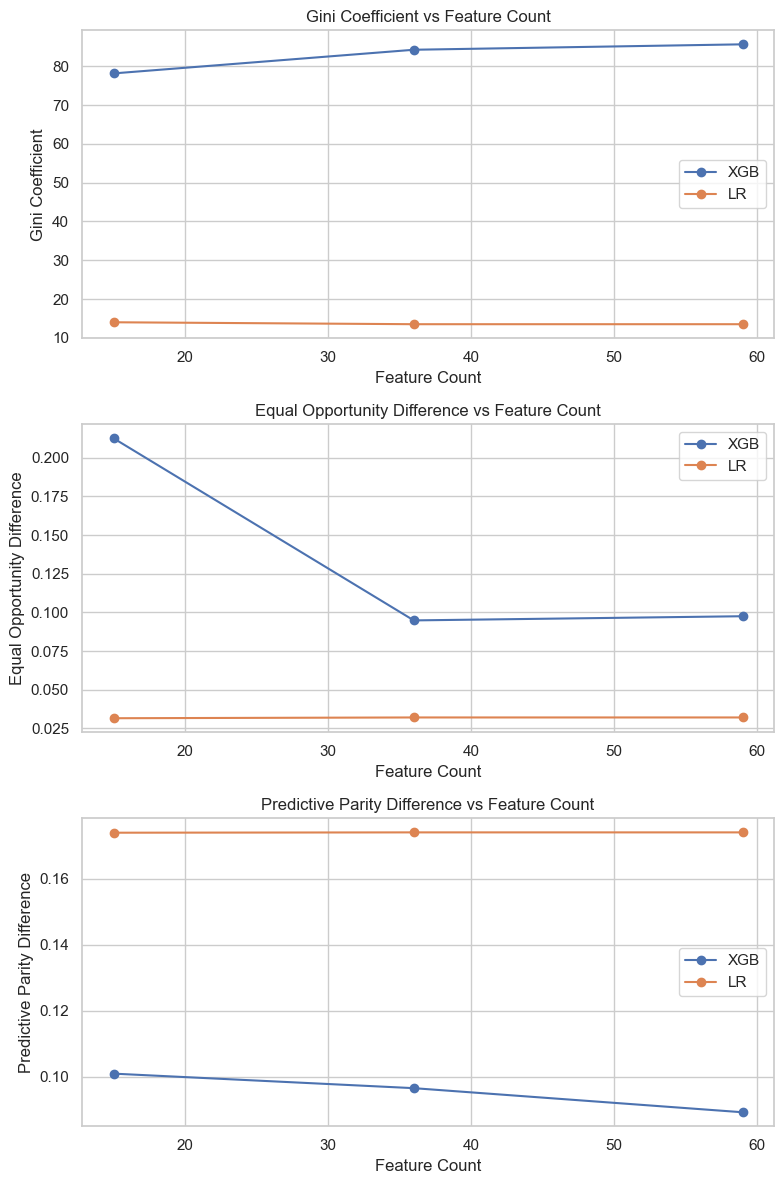

t-test results for Gini Coefficient: t = 29.91921288095963, p = 7.432297881270834e-06
t-test results for Equal Opportunity Difference: t = 2.6563743675883944, p = 0.0566039702872307
t-test results for Predictive Parity Difference: t = -22.98702298703448, p = 2.1220752267562055e-05


In [26]:
# Create subplots for Gini, Equal Opportunity Difference, and Predictive Parity Difference
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Plot Gini coefficients
axes[0].plot(feature_counts, gini_xgb, marker='o', label='XGB')
axes[0].plot(feature_counts, gini_lr, marker='o', label='LR')
axes[0].set_xlabel('Feature Count')
axes[0].set_ylabel('Gini Coefficient')
axes[0].set_title('Gini Coefficient vs Feature Count')
axes[0].legend()

# Plot Equal Opportunity Difference
axes[1].plot(feature_counts, equal_opp_diff_xgb, marker='o', label='XGB')
axes[1].plot(feature_counts, equal_opp_diff_lr, marker='o', label='LR')
axes[1].set_xlabel('Feature Count')
axes[1].set_ylabel('Equal Opportunity Difference')
axes[1].set_title('Equal Opportunity Difference vs Feature Count')
axes[1].legend()

# Plot Predictive Parity Difference
axes[2].plot(feature_counts, predictive_parity_diff_xgb, marker='o', label='XGB')
axes[2].plot(feature_counts, predictive_parity_diff_lr, marker='o', label='LR')
axes[2].set_xlabel('Feature Count')
axes[2].set_ylabel('Predictive Parity Difference')
axes[2].set_title('Predictive Parity Difference vs Feature Count')
axes[2].legend()

plt.tight_layout()
plt.show()

# Perform t-tests
t_statistic_gini, p_value_gini = ttest_ind(gini_xgb, gini_lr)
t_statistic_equal_opp, p_value_equal_opp = ttest_ind(equal_opp_diff_xgb, equal_opp_diff_lr)
t_statistic_predictive_parity, p_value_predictive_parity = ttest_ind(predictive_parity_diff_xgb, predictive_parity_diff_lr)

print(f"t-test results for Gini Coefficient: t = {t_statistic_gini}, p = {p_value_gini}")
print(f"t-test results for Equal Opportunity Difference: t = {t_statistic_equal_opp}, p = {p_value_equal_opp}")
print(f"t-test results for Predictive Parity Difference: t = {t_statistic_predictive_parity}, p = {p_value_predictive_parity}")


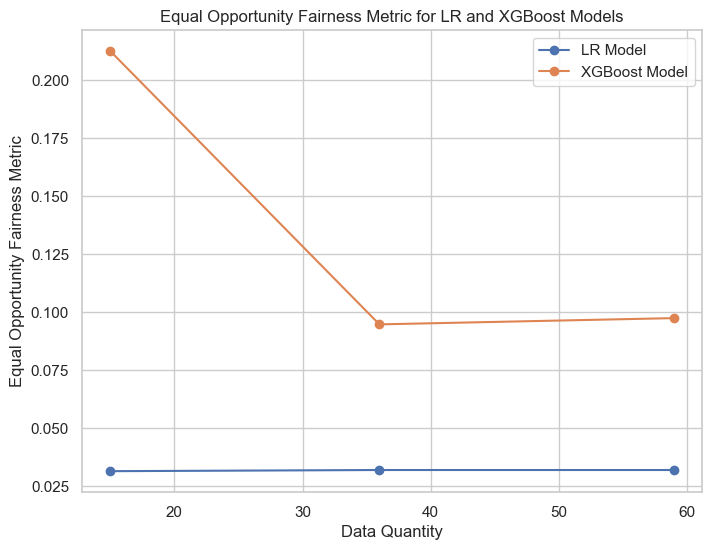

In [27]:
# Data for LR model's equal opportunity fairness metric
data_lr = {
    "Data Quantity": [15, 36, 59],  # Varying data quantities
    "Equal Opportunity Fairness (LR)": [0.0315, 0.0320, 0.0320]  # Equal opportunity fairness metric values for LR
}

# Data for XGBoost model's equal opportunity fairness metric
data_xgb = {
    "Data Quantity": [15, 36, 59],  # Varying data quantities
    "Equal Opportunity Fairness (XGB)": [0.2126, 0.0948, 0.0975]  # Equal opportunity fairness metric values for XGBoost
}

# Create a line plot
plt.figure(figsize=(8, 6))

# Plot equal opportunity fairness metrics for LR and XGBoost models
plt.plot(data_lr["Data Quantity"], data_lr["Equal Opportunity Fairness (LR)"], marker='o', label='LR Model')
plt.plot(data_xgb["Data Quantity"], data_xgb["Equal Opportunity Fairness (XGB)"], marker='o', label='XGBoost Model')

# Add labels and title
plt.xlabel("Data Quantity")
plt.ylabel("Equal Opportunity Fairness Metric")
plt.title("Equal Opportunity Fairness Metric for LR and XGBoost Models")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


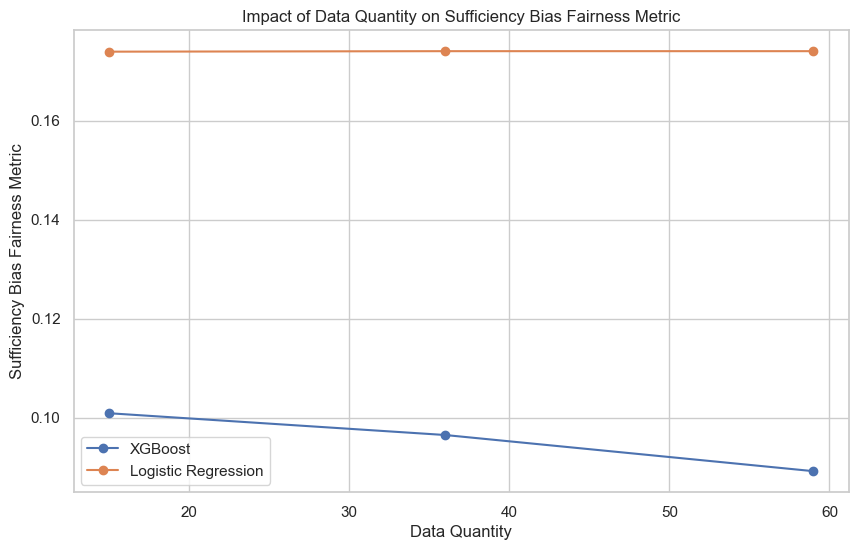

In [28]:
# Data for the line plots
data_quantity = [15, 36, 59]
sufficiency_bias_xgb = [0.1009, 0.0965, 0.0892]  # sufficiency bias values for XGBoost
sufficiency_bias_lr = [0.1739,  0.1740, 0.1740]   # sufficiency bias values for Logistic Regression

# Create the line plots
plt.figure(figsize=(10, 6))

plt.plot(data_quantity, sufficiency_bias_xgb, marker='o', label='XGBoost')
plt.plot(data_quantity, sufficiency_bias_lr, marker='o', label='Logistic Regression')

plt.xlabel('Data Quantity')
plt.ylabel('Sufficiency Bias Fairness Metric')
plt.title('Impact of Data Quantity on Sufficiency Bias Fairness Metric')
plt.legend()
plt.grid(True)

plt.savefig('sufficiency_bias_fairness.png')  # Save the figure as an image
plt.show()
